# Note Bloat Project

## Data Loading

### Library Imports

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk import ngrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sentence_transformers import SentenceTransformer

In [69]:
# Uncomment the following line if you haven't downloaded the NLTK 'punkt' resource before
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

### MIMIC III Data Extraction

In [70]:
# Data Path
data_path = '/content/drive/MyDrive/MIDS 266/Final Project/Data/'

In [4]:
def sample_and_save(df, output_filename='sample.csv', n_rows=10000, random_state=None):
    """
    Sample n_rows random rows from the dataframe `df` and save them to a CSV file.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - output_filename (str): The filename for the output CSV.
    - n_rows (int): Number of random rows to sample.
    - random_state (int or None): Seed for reproducibility; if None, random seed is not fixed.
    """
    # Check if the dataframe has fewer rows than desired
    if len(df) < n_rows:
        raise ValueError(f"DataFrame only has {len(df)} rows, but {n_rows} rows were requested.")

    # Randomly sample n_rows from the DataFrame (without replacement by default)
    sample_df = df.sample(n=n_rows, random_state=random_state)

    # Save the sampled DataFrame to a CSV file
    sample_df.to_csv(output_filename, index=False)
    print(f"Saved {n_rows} random rows to {output_filename}")


In [71]:
def stratified_sample_and_save(
      df,
      data_path='/content/drive/MyDrive/MIDS 266/Final Project/Data/',
      output_train='train.csv',
      output_val='validation.csv',
      output_test='test.csv',
      random_state=None,
      train_frac=0.7,
      val_frac=0.15,
      test_frac=0.15):
    """
    Sample balanced rows from the DataFrame df stratified on 'CATEGORY',
    and split the result into three files for training, validation, and test.

    The function handles imbalanced categories by sampling the minimum
    number of rows found in any category.

    Parameters:
      df (pd.DataFrame): The input DataFrame.
      output_train (str): Filename for the training CSV.
      output_val (str): Filename for the validation CSV.
      output_test (str): Filename for the test CSV.
      random_state (int or None): Seed for reproducibility.
      train_frac (float): Fraction of total rows for training.
      val_frac (float): Fraction of total rows for validation.
      test_frac (float): Fraction of total rows for testing.
    """
    import pandas as pd

    # Ensure the split fractions sum to 1
    total_frac = train_frac + val_frac + test_frac
    if total_frac != 1:
        raise ValueError("train_frac, val_frac, and test_frac must sum to 1.")

    categories = df['CATEGORY'].unique()
    n_categories = len(categories)

    # Determine the minimum available rows per category
    min_rows_per_cat = min(len(df[df['CATEGORY'] == cat]) for cat in categories)

    # Create a balanced sample from each category
    sampled_dfs = []
    for cat in categories:
        df_cat = df[df['CATEGORY'] == cat]
        sample_cat = df_cat.sample(n=min_rows_per_cat, random_state=random_state)
        sampled_dfs.append(sample_cat)

    # Combine the stratified samples and shuffle the result
    final_sample = pd.concat(sampled_dfs)
    final_sample = final_sample.sample(frac=1, random_state=random_state)

    # Calculate the sizes for each split
    total_rows = len(final_sample)
    n_train = int(total_rows * train_frac)
    n_val = int(total_rows * val_frac)
    n_test = total_rows - n_train - n_val  # Ensure all rows are assigned

    # Split the dataframe into train, validation, and test
    train_df = final_sample.iloc[:n_train]
    val_df = final_sample.iloc[n_train:n_train+n_val]
    test_df = final_sample.iloc[n_train+n_val:]

    # Save the splits to their corresponding files
    train_df.to_csv((data_path + output_train), index=False)
    val_df.to_csv((data_path + output_val), index=False)
    test_df.to_csv((data_path + output_test), index=False)

    print(f"Saved {len(train_df)} training rows to {output_train}")
    print(f"Saved {len(val_df)} validation rows to {output_val}")
    print(f"Saved {len(test_df)} test rows to {output_test}")


In [40]:
def check_category_distribution(df, column='CATEGORY'):
    """
    Check and print the distribution of values for a specified column.

    Parameters:
      df (pd.DataFrame): The input DataFrame.
      column (str): The column name to analyze (default is 'CATEGORY').
    """
    # Compute raw counts for each category
    counts = df[column].value_counts()

    # Compute percentages for each category
    percentages = df[column].value_counts(normalize=True) * 100

    # Display results
    print("Category Distribution (Counts):")
    print(counts)
    print("\nCategory Distribution (Percentages):")
    print(percentages)

def plot_category_distribution(df, column='CATEGORY', figsize=(8,6),
                               color='skyblue'):
    """
    Create a bar plot to visualize the distribution of values for a given
    column in the DataFrame.

    Parameters:
      df (pd.DataFrame): The input DataFrame.
      column (str): The column name to plot (default 'CATEGORY').
      figsize (tuple): Figure size (default (8,6)).
      color (str): Bar color (default 'skyblue').
    """
    # Compute counts for each category
    counts = df[column].value_counts()

    # Create the horizontal bar plot
    plt.figure(figsize=figsize)
    counts.plot(kind='barh', color=color)
    plt.title('Category Distribution')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


Category Distribution (Counts):
CATEGORY
Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: count, dtype: int64

Category Distribution (Percentages):
CATEGORY
Nursing/other        39.482762
Radiology            25.071237
Nursing              10.731478
ECG                  10.035187
Physician             6.798452
Discharge summary     2.863507
Echo                  2.198274
Respiratory           1.523584
Nutrition             0.452097
General               0.398477
Rehab Services        0.260707
Social Work           0.128169
Case Management       0.046419
Pharmacy              0.004944
Consult               0.004704
N

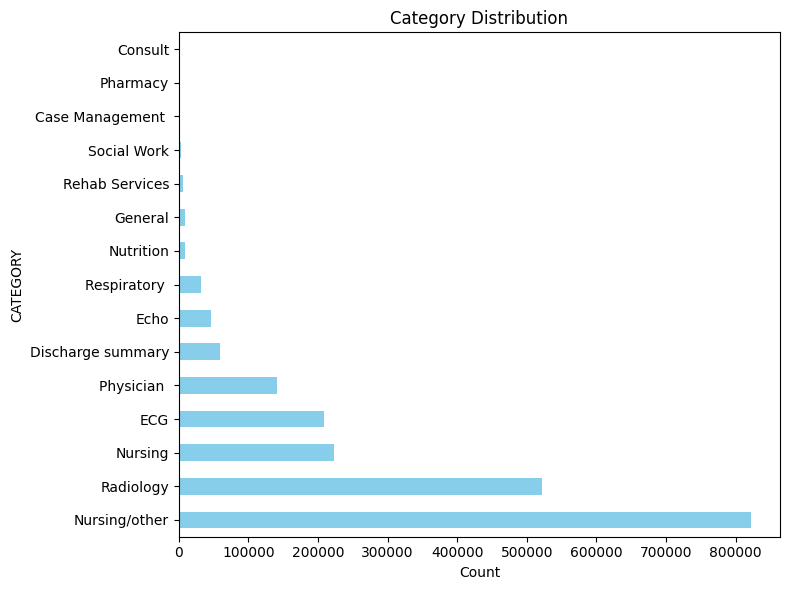

(2083180, 14)
Category Distribution (Counts):
CATEGORY
Rehab Services       98
ECG                  98
Case Management      98
Nursing/other        98
Radiology            98
Social Work          98
Nursing              98
Echo                 98
Discharge summary    98
Physician            98
Consult              98
General              98
Nutrition            98
Respiratory          98
Pharmacy             98
Name: count, dtype: int64

Category Distribution (Percentages):
CATEGORY
Rehab Services       6.666667
ECG                  6.666667
Case Management      6.666667
Nursing/other        6.666667
Radiology            6.666667
Social Work          6.666667
Nursing              6.666667
Echo                 6.666667
Discharge summary    6.666667
Physician            6.666667
Consult              6.666667
General              6.666667
Nutrition            6.666667
Respiratory          6.666667
Pharmacy             6.666667
Name: proportion, dtype: float64


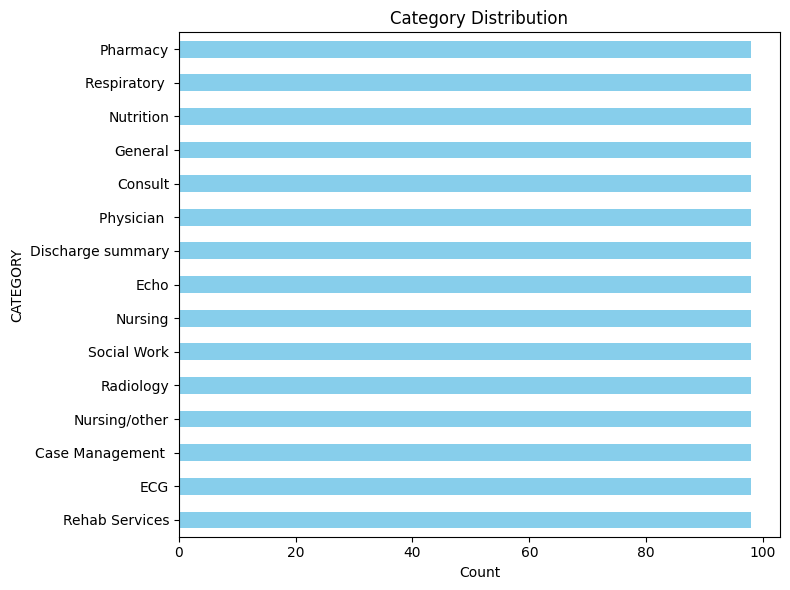

(1470, 14)


In [42]:
check_category_distribution(df2)
plot_category_distribution(df2)
print(df2.shape)

check_category_distribution(df)
plot_category_distribution(df)
print(df.shape)

In [72]:
# Stratified Dataset Sample
file_name = 'cleaned_mimic_iii_noteEvents_2.csv'
file_path = data_path + file_name
df2 = pd.read_csv(file_path)

# Save stratified sample
stratified_sample_and_save(
    df2,
    random_state=42)

Saved 1029 training rows to train.csv
Saved 220 validation rows to validation.csv
Saved 221 test rows to test.csv


In [74]:
# Load data
# file_name = 'cleaned_mimic_iii_noteEvents_2.csv'
# file_name = 'sample_mimic_iii_noteEvents.csv'
file_name = 'train.csv'
file_path = data_path + file_name
df = pd.read_csv(file_path)
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,clean_text,word_count,redundancy_score
0,482602,70505,148384.0,2187-10-09,2187-10-09 10:47:00,2187-10-09 10:47:41,Rehab Services,Bedside Swallow Evaluation,21316.0,NaN,"TITLE: BEDSIDE SWALLOWING EVALUATION:\n HISTORY:\n Thank you for referring this 73 yr old male admitted on [**2187-9-25**] from\n OSH, intubated with hypotension, hematemesis, ARF, and leukocytosis.\n Of note, pt was involved in an MVA 1 wk prior to admit, after which he\n left hospital AMA. PMH significant for cirrhosis with ascites and ETOH\n abuse. On [**9-25**] pt underwent EGD and was found to have grade III\n varices, which were banded. Hospital course also c/b prolonged\n intubation, leukocytosis, and encephalopathy. Pt was extubated on\n [**10-7**]. CXR on [**10-8**] revealed bilat pleural effusions. Pt was receiving\n tube feedings, however they were stopped with extubation. We were\n consulted to evaluate oral and pharyngeal swallow function to determine\n the safest diet.\n PMH:\n HTN, Hyperglycemia, Hyperlipidemia, Gout, GERD, Hiatal hernia,\n Cirrhosis/Splenomegaly, Cholelithiasis, Hx of traumatic fx of nose,\n BPH, Hx of facial erysipelas\n EVALUATION:\n The examination was performed while the patient was seated upright in\n the bed on MICU. A Portuguese speaking interpreter was present during\n the eval.\n Cognition, language, speech, voice:\n Pt was alert, but disoriented throughout the eval. He stated his name\n on request, but per interpreter the majority of other utterances were\n tangentially related at best. Vocal quality was clear, but low in\n volume.\n Teeth: Present, but in fair to poor condition.\n Secretions: Mouth was coated with dried dark red blood. Gentle oral\n care attempted with spongette and resulted in active bleeding from L\n cheek and lip.\n ORAL MOTOR EXAM:\n Face was grossly symmetrical. Tongue protruded at midline with reduced\n strength and ROM. Labial seal was intact. Palatal elevation was\n symmetric. Gag was present.\n SWALLOWING ASSESSMENT:\n Pt was offered ice chips, thin liquids (tsp, cup, straw), nectar (tsp,\n straw), and puree. Chewable solids deferred given active bleeding in\n mouth. Oral phase prolonged, but without residue or anterior spill.\n Laryngeal elevation was difficult to palpate given excess tissue. Pt\n had throat clear with multiple straw sips of thin liquids. Otherwise,\n no other signs of aspiration were present. Pt unable to accurately\n state sensation of aspiration or pharyngeal residue.\n SUMMARY / IMPRESSION:\n Pt presents with signs of aspiration of thin liquid and decreased\n mental status, which likely will limit volume of PO intake. He appears\n safe for pureed solids and nectar thick liquids by straw. He may\n require supplemental non-oral intake if mental status does not\n improve. Nutrition f/u encouraged. 1:1 supervision to maintain\n aspiration precautions and assist with self-feed. We will check back\n at the end of the week for upgrades as appropriate.\n This swallowing pattern correlates to a Functional Oral Intake Scale\n (FOIS) rating of 5 out of 7.\n RECOMMENDATIONS:\n 1.) PO diet of pureed solids and nectar thick liquids\n 2.) PO meds crushed in puree\n 3.) Q4 oral care\n 4.) 1:1 supervision with meals to maintain aspiration precautions and\n assist with self-feed\n 5.) Consult nutrition\n 6.) Will f/u later in the week\n These recommendations were shared with the patient, nurse and medical\n team.\n __________________________________\n [**First Name8 (NamePattern2) 9911**] [**Last Name (NamePattern1) 9912**], B.A., SLP/s\n Pager# [**Serial Number 5879**]\n ____________________________________\n [**Doctor First Name 3274**] Whitmill, M.S., CCC-SLP\n Pager #[**Numeric Identifier 5011**]\n Face time: 10:00-10:20\n Total time: 75min\n",title bedside swallowing evaluation history thank you for referring this 73 yr old male admitted on 2187925 from osh intubated with hypotension hemat

In [ ]:
# Load the dataset (make sure the file is in your working directory)
df = pd.read_csv(mimic3)
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,1353394,6878,121907.0,2112-01-27,2112-01-27 14:53:00,2112-01-27 15:34:00,Nursing/other,Report,19279.0,NaN,NEURO~A&O X3. EPISODE OF AGITATION & ANGER THI...
1,250549,41246,103886.0,2163-11-07,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with ventricular pacing. N...
2,1341701,6032,130989.0,2191-11-18,2191-11-18 16:30:00,2191-11-18 16:31:00,Nursing/other,Report,19950.0,NaN,"Resp Care\nPt remains intubated on MMV, RR/pat..."
3,1419129,11951,174454.0,2195-08-23,2195-08-23 18:39:00,2195-08-23 18:41:00,Nursing/other,Report,15225.0,NaN,Brief Update MICU NPN:\nPt c/o constipation an...
4,949695,19455,119088.0,2174-03-16,2174-03-16 13:18:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2174-3-16**] 1:18 PM\n CHEST (PORTABLE AP) ...


In [ ]:
# Print summary information about the dataset
print("Dataset Info:")
print(df.info(), "\n")

# Check for missing values
print("Missing Values Summary:")
print(df.isnull().sum(), "\n")

print("First 5 rows:")
df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083180 entries, 0 to 2083179
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ROW_ID       int64  
 1   SUBJECT_ID   int64  
 2   HADM_ID      float64
 3   CHARTDATE    object 
 4   CHARTTIME    object 
 5   STORETIME    object 
 6   CATEGORY     object 
 7   DESCRIPTION  object 
 8   CGID         float64
 9   ISERROR      float64
 10  TEXT         object 
dtypes: float64(3), int64(2), object(6)
memory usage: 174.8+ MB
None 

Missing Values Summary:
ROW_ID               0
SUBJECT_ID           0
HADM_ID         231836
CHARTDATE            0
CHARTTIME       316566
STORETIME       836776
CATEGORY             0
DESCRIPTION          0
CGID            836776
ISERROR        2082294
TEXT                 0
dtype: int64 

First 5 rows:


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,1353394,6878,121907.0,2112-01-27,2112-01-27 14:53:00,2112-01-27 15:34:00,Nursing/other,Report,19279.0,NaN,NEURO~A&O X3. EPISODE OF AGITATION & ANGER THI...
1,250549,41246,103886.0,2163-11-07,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with ventricular pacing. N...
2,1341701,6032,130989.0,2191-11-18,2191-11-18 16:30:00,2191-11-18 16:31:00,Nursing/other,Report,19950.0,NaN,"Resp Care\nPt remains intubated on MMV, RR/pat..."
3,1419129,11951,174454.0,2195-08-23,2195-08-23 18:39:00,2195-08-23 18:41:00,Nursing/other,Report,15225.0,NaN,Brief Update MICU NPN:\nPt c/o constipation an...
4,949695,19455,119088.0,2174-03-16,2174-03-16 13:18:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2174-3-16**] 1:18 PM\n CHEST (PORTABLE AP) ...


## Text Cleaning and Tokenization

### Text Cleaning

In [ ]:
import re
import pandas as pd

def clean_text(text: str):
    """
    Clean and preprocess a text string.

    This function converts the input text to lowercase, removes punctuation
    using a simple regular expression, collapses multiple whitespace
    characters into a single space, and trims leading or trailing spaces.
    If the input is None or a pandas null value, an empty string is returned.
    The input must be a string.

    Parameters
    ----------
    text : str
        The text to be cleaned. The input must be a string. If the text
        is None or a pandas null value, an empty string is returned.

    Returns
    -------
    str
        The cleaned and normalized text string.

    Raises
    ------
    TypeError
        If the input is not a string.
    """

    # Return empty string if text is None or a pandas null value
    if pd.isnull(text):
        return ""

    # Validate the input type is a string
    if not isinstance(text, str):
        raise TypeError("The input text must be a string.")

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation (simple regex; extend as needed)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
# Apply text cleaning on the 'TEXT' column
df['clean_text'] = df['TEXT'].apply(clean_text)

df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,clean_text
0,1353394,6878,121907.0,2112-01-27,2112-01-27 14:53:00,2112-01-27 15:34:00,Nursing/other,Report,19279.0,NaN,NEURO~A&O X3. EPISODE OF AGITATION & ANGER THI...,neuroao x3 episode of agitation anger this am ...
1,250549,41246,103886.0,2163-11-07,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with ventricular pacing. N...,atrial fibrillation with ventricular pacing no...
2,1341701,6032,130989.0,2191-11-18,2191-11-18 16:30:00,2191-11-18 16:31:00,Nursing/other,Report,19950.0,NaN,"Resp Care\nPt remains intubated on MMV, RR/pat...",resp care pt remains intubated on mmv rrpatter...
3,1419129,11951,174454.0,2195-08-23,2195-08-23 18:39:00,2195-08-23 18:41:00,Nursing/other,Report,15225.0,NaN,Brief Update MICU NPN:\nPt c/o constipation an...,brief update micu npn pt co constipation and g...
4,949695,19455,119088.0,2174-03-16,2174-03-16 13:18:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2174-3-16**] 1:18 PM\n CHEST (PORTABLE AP) ...,2174316 118 pm chest portable ap clip clip num...


### Tokenization

In [ ]:
# Compute the word count for each note
df['word_count'] = df['clean_text'].apply(lambda x: len(nltk.word_tokenize(x)))
print("Descriptive statistics for word count:")
print(df['word_count'].describe(), "\n")

Descriptive statistics for word count:
count    2.083180e+06
mean     2.418094e+02
std      3.322925e+02
min      0.000000e+00
25%      6.500000e+01
50%      1.430000e+02
75%      2.650000e+02
max      7.779000e+03
Name: word_count, dtype: float64 



In [ ]:
# Making a copy of the dataframe with the cleaned values
cleaned_df = df.copy()

In [ ]:
cleaned_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT,clean_text,word_count
0,1353394,6878,121907.0,2112-01-27,2112-01-27 14:53:00,2112-01-27 15:34:00,Nursing/other,Report,19279.0,NaN,NEURO~A&O X3. EPISODE OF AGITATION & ANGER THI...,neuroao x3 episode of agitation anger this am ...,281
1,250549,41246,103886.0,2163-11-07,NaN,NaN,ECG,Report,NaN,NaN,Atrial fibrillation with ventricular pacing. N...,atrial fibrillation with ventricular pacing no...,13
2,1341701,6032,130989.0,2191-11-18,2191-11-18 16:30:00,2191-11-18 16:31:00,Nursing/other,Report,19950.0,NaN,"Resp Care\nPt remains intubated on MMV, RR/pat...",resp care pt remains intubated on mmv rrpatter...,23
3,1419129,11951,174454.0,2195-08-23,2195-08-23 18:39:00,2195-08-23 18:41:00,Nursing/other,Report,15225.0,NaN,Brief Update MICU NPN:\nPt c/o constipation an...,brief update micu npn pt co constipation and g...,76
4,949695,19455,119088.0,2174-03-16,2174-03-16 13:18:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2174-3-16**] 1:18 PM\n CHEST (PORTABLE AP) ...,2174316 118 pm chest portable ap clip clip num...,205


## Note Length

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# file_name = 'cleaned_mimic_iii_noteEvents_2.csv'
# file_path = data_path + file_name
# cleaned_df = pd.read_csv(file_path)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['word_count'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Distribution of Note Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Note Redundancy

In [30]:
def compute_redundancy(text, n=2):
    """
    Compute a redundancy score based on repeated n-grams.

    The score is computed as the total count of repeated n-grams (i.e., the
    count of occurrences beyond the first for each n-gram) divided by the
    total number of n-grams in the input text.

    Parameters
    ----------
    text : str
        The text to be analyzed. Must be a string.
    n : int
        The n-gram length. Must be an integer greater than 0.

    Returns
    -------
    float
        The redundancy score as a float value.

    Raises
    ------
    TypeError
        If text is not a string or n is not an integer.
    ValueError
        If n is less than or equal to 0.
    """
    import nltk
    from nltk.util import ngrams
    from collections import Counter

    # Validate input: text must be a string.
    if not isinstance(text, str):
        raise TypeError("text must be a string.")
    # Validate n is a positive integer.
    if not isinstance(n, int):
        raise TypeError("n must be an integer.")
    if n <= 0:
        raise ValueError("n must be greater than 0.")

    tokens = nltk.word_tokenize(text)
    if len(tokens) < n:
        return 0.0

    ngram_list = list(ngrams(tokens, n))
    ngram_counts = Counter(ngram_list)

    # Count duplicate occurrences for n-grams occurring more than once.
    duplicates = sum(
        count - 1
        for count in ngram_counts.values()
        if count > 1
    )
    total_ngrams = len(ngram_list)
    redundancy_score = (
        duplicates / total_ngrams if total_ngrams > 0 else 0.0
    )
    return redundancy_score


In [ ]:
# Apply the redundancy function for bi-grams (n=2)
cleaned_df['redundancy_score'] = cleaned_df['clean_text'].apply(lambda x: compute_redundancy(x, n=2))

print("Descriptive statistics for redundancy scores:")
print(cleaned_df['redundancy_score'].describe(), "\n")

Descriptive statistics for redundancy scores:
count    2.083180e+06
mean     6.605419e-02
std      7.020753e-02
min      0.000000e+00
25%      1.195219e-02
50%      4.830918e-02
75%      9.230769e-02
max      8.947216e-01
Name: redundancy_score, dtype: float64 



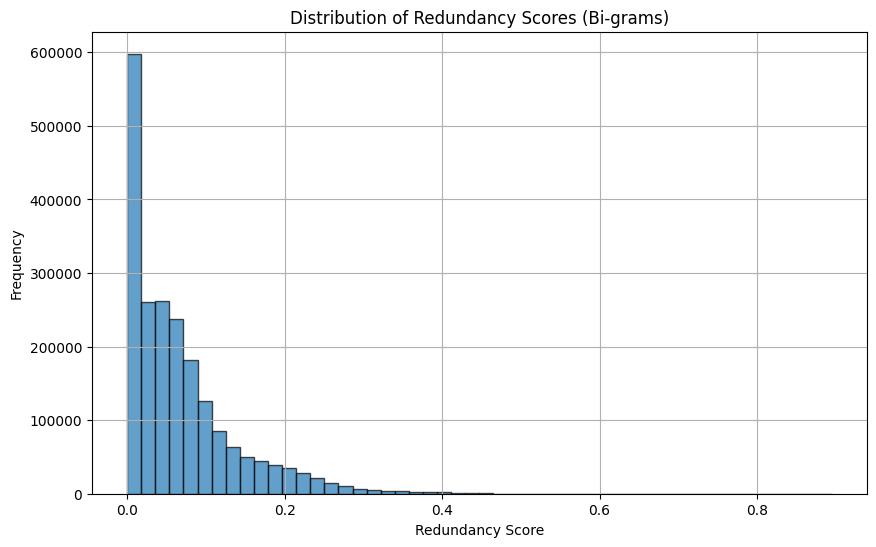

In [ ]:
# Plot the redundancy of bi-grams
plt.figure(figsize=(10, 6))
plt.hist(cleaned_df['redundancy_score'], bins=50, edgecolor='k', alpha=0.7)
plt.title("Distribution of Redundancy Scores (Bi-grams)")
plt.xlabel("Redundancy Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### Correlation of Word Count and Redundancy

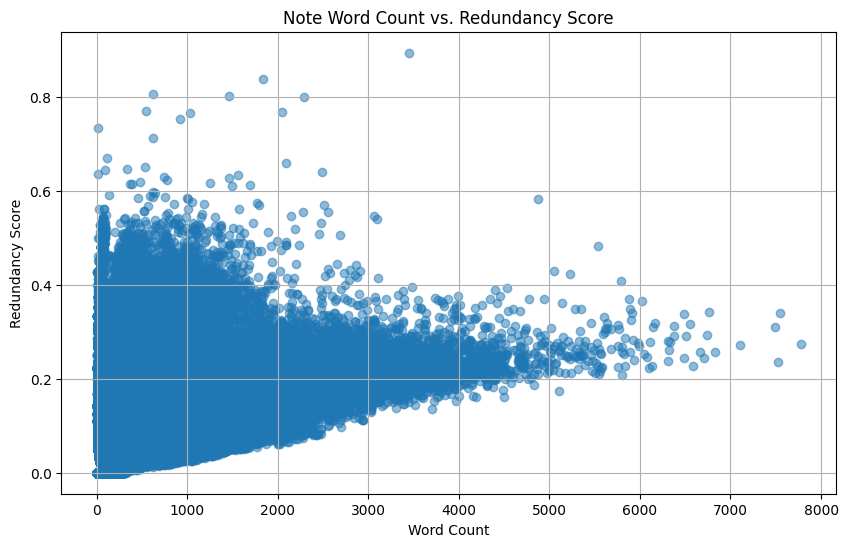

In [ ]:
# Scatter plot: word count vs redundancy score
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_df['word_count'], cleaned_df['redundancy_score'], alpha=0.5)
plt.title("Note Word Count vs. Redundancy Score")
plt.xlabel("Word Count")
plt.ylabel("Redundancy Score")
plt.grid(True)
plt.show()


In [ ]:
# Compute correlation between note word count and redundancy score
correlation = cleaned_df[['word_count', 'redundancy_score']].corr()
print("Correlation matrix:")
print(correlation, "\n")


Correlation matrix:
                  word_count  redundancy_score
word_count          1.000000          0.419258
redundancy_score    0.419258          1.000000 



In [ ]:
# save data for easy loading
file_name = 'cleaned_mimic_iii_noteEvents_2.csv'
file_path = data_path + file_name
cleaned_df.to_csv(file_path, index=False)
print(f"DataFrame saved to {file_path}")


DataFrame saved to /content/drive/MyDrive/MIDS 266/Final Project/Data/cleaned_mimic_iii_noteEvents_2.csv


### TF-IDF and Cosine Similarity

This section shows how you might begin to explore similarity within notes using Term Frequency–Inverse Document Frequency (TF-IDF).
For example, comparing sections if you have such annotations.
Here, we vectorize the full text and calculate the average cosine similarity between notes.


In [ ]:
# Load stratified Dataset
file_name = 'stratified_25k_sample_mimic_iii_noteEvents.csv'
file_path = data_path + file_name
df = pd.read_csv(file_path)
df.head()

In [33]:
df.shape

(1470, 14)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Replace NaN values with empty strings in the 'clean_text' column
# for compatibility with the tf-idf
df['clean_text'] = df['clean_text'].fillna('')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
cosine_sim_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()

# For demonstration, print the average cosine similarity across the dataset (excluding self-similarity)
cosine_sim_sum = cosine_sim_matrix.sum() - len(df)  # subtract diagonal (self-similarity)
average_cosine_sim = cosine_sim_sum / (len(df)**2 - len(df))
print(f"Average cosine similarity between notes: {average_cosine_sim:.4f}")


Average cosine similarity between notes: 0.0832


Average cosine similarity between notes: 0.0832

A low overall average cosine similarity (0.0832) across all notes suggests that, at the document level, many notes aren’t very similar to one another. However, note bloat typically manifests as excessive repetition within individual notes or among similar sections (for example, repeated copy‐and‐paste content within progress notes). To tackle this, we will adopt a more granular strategy.

### Between-Note Similarity Analysis

We'll be comparing notes from within different departments and looking at cosine similarity in notes for patterns.


In [43]:
def compute_avg_cosine_similarity(notes, sample_size=1000):
    """
    Given a pandas Series (notes), compute the average cosine similarity (excluding self-similarity)
    using TF-IDF vectorization.

    If there are many notes, sample up to sample_size to manage computation time.
    """
    # If too many notes, sample randomly for efficiency.
    if len(notes) > sample_size:
        notes = notes.sample(sample_size, random_state=42)

    # Vectorize the notes using TF-IDF.
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(notes)

    # Compute the cosine similarity matrix.
    cos_sim_matrix = cosine_similarity(tfidf_matrix)

    n = cos_sim_matrix.shape[0]
    # Remove self-similarities (diagonal of 1's) before averaging.
    sum_sim = cos_sim_matrix.sum() - n
    count = n * (n - 1)  # Number of off-diagonal elements
    avg_sim = sum_sim / count if count > 0 else 0
    return avg_sim

In [44]:
# Create a dictionary to store average cosine similarity scores for each department.
results = {}

# Loop over each unique department (e.g., Radiology, Physician, Nursing, etc.)
for dept in df['CATEGORY'].unique():
    dept_notes = df[df['CATEGORY'] == dept]['clean_text']
    if len(dept_notes) < 2:
        continue  # Skip if there is not enough data for a meaningful comparison
    avg_sim = compute_avg_cosine_similarity(dept_notes)
    results[dept] = avg_sim
    print(f"Department: {dept}, Number of Notes: {len(dept_notes)}, Avg Cosine Similarity: {avg_sim:.4f}")


Department: Rehab Services, Number of Notes: 98, Avg Cosine Similarity: 0.1795
Department: ECG, Number of Notes: 98, Avg Cosine Similarity: 0.1082
Department: Case Management , Number of Notes: 98, Avg Cosine Similarity: 0.1384
Department: Nursing/other, Number of Notes: 98, Avg Cosine Similarity: 0.0574
Department: Radiology, Number of Notes: 98, Avg Cosine Similarity: 0.0957
Department: Social Work, Number of Notes: 98, Avg Cosine Similarity: 0.1537
Department: Nursing, Number of Notes: 98, Avg Cosine Similarity: 0.0980
Department: Echo, Number of Notes: 98, Avg Cosine Similarity: 0.3809
Department: Discharge summary, Number of Notes: 98, Avg Cosine Similarity: 0.2450
Department: Physician , Number of Notes: 98, Avg Cosine Similarity: 0.2623
Department: Consult, Number of Notes: 98, Avg Cosine Similarity: 0.2293
Department: General, Number of Notes: 98, Avg Cosine Similarity: 0.0646
Department: Nutrition, Number of Notes: 98, Avg Cosine Similarity: 0.0472
Department: Respiratory , Nu

In [45]:
def compute_cross_avg_cosine_similarity(notes1, notes2, sample_size=1000):
    """
    Compute the average cosine similarity between two sets of notes.
    If the sets are large, sample up to sample_size notes from each to manage computation time.
    The notes are vectorized together using TF-IDF to ensure a consistent feature space.
    """
    # Sample if necessary for efficiency
    # if len(notes1) > sample_size:
    #     notes1 = notes1.sample(sample_size, random_state=42)
    # if len(notes2) > sample_size:
    #     notes2 = notes2.sample(sample_size, random_state=42)

    # Combine the two sets to build a consistent vocabulary
    all_notes = pd.Series(notes1 + notes2)
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix_all = vectorizer.fit_transform(all_notes)

    # Split the matrix into two parts
    tfidf1 = tfidf_matrix_all[:len(notes1)]
    tfidf2 = tfidf_matrix_all[len(notes1):]

    # Compute cosine similarity between every note in group1 and every note in group2
    sims = cosine_similarity(tfidf1, tfidf2)
    avg_sim = sims.mean()
    return avg_sim

In [46]:
# -------------------------------
# 4. Compute Pairwise Between-Note Cosine Similarity
# -------------------------------

# Group the cleaned text by department (using 'CATEGORY')
dept_groups = df.groupby('CATEGORY')['clean_text'].apply(list)
departments = dept_groups.index.tolist()

# Create a DataFrame to hold the pairwise similarity values
similarity_matrix = pd.DataFrame(index=departments, columns=departments, dtype=float)

# Loop over each pair of departments and compute the average cosine similarity
for dept1 in departments:
    notes1 = dept_groups[dept1]
    for dept2 in departments:
        notes2 = dept_groups[dept2]
        avg_sim = compute_cross_avg_cosine_similarity(notes1, notes2)
        similarity_matrix.loc[dept1, dept2] = avg_sim
        print(f"Avg Cosine Similarity between {dept1.strip()} and {dept2.strip()}: {avg_sim:.4f}")

print("\nPairwise Cosine Similarity Matrix:")
print(similarity_matrix)


Avg Cosine Similarity between Case Management and Case Management: 0.1434
Avg Cosine Similarity between Case Management and Consult: 0.0411
Avg Cosine Similarity between Case Management and Discharge summary: 0.0682
Avg Cosine Similarity between Case Management and ECG: 0.0031
Avg Cosine Similarity between Case Management and Echo: 0.0069
Avg Cosine Similarity between Case Management and General: 0.0360
Avg Cosine Similarity between Case Management and Nursing: 0.0392
Avg Cosine Similarity between Case Management and Nursing/other: 0.0273
Avg Cosine Similarity between Case Management and Nutrition: 0.0182
Avg Cosine Similarity between Case Management and Pharmacy: 0.0281
Avg Cosine Similarity between Case Management and Physician: 0.0417
Avg Cosine Similarity between Case Management and Radiology: 0.0132
Avg Cosine Similarity between Case Management and Rehab Services: 0.0560
Avg Cosine Similarity between Case Management and Respiratory: 0.0220
Avg Cosine Similarity between Case Manage

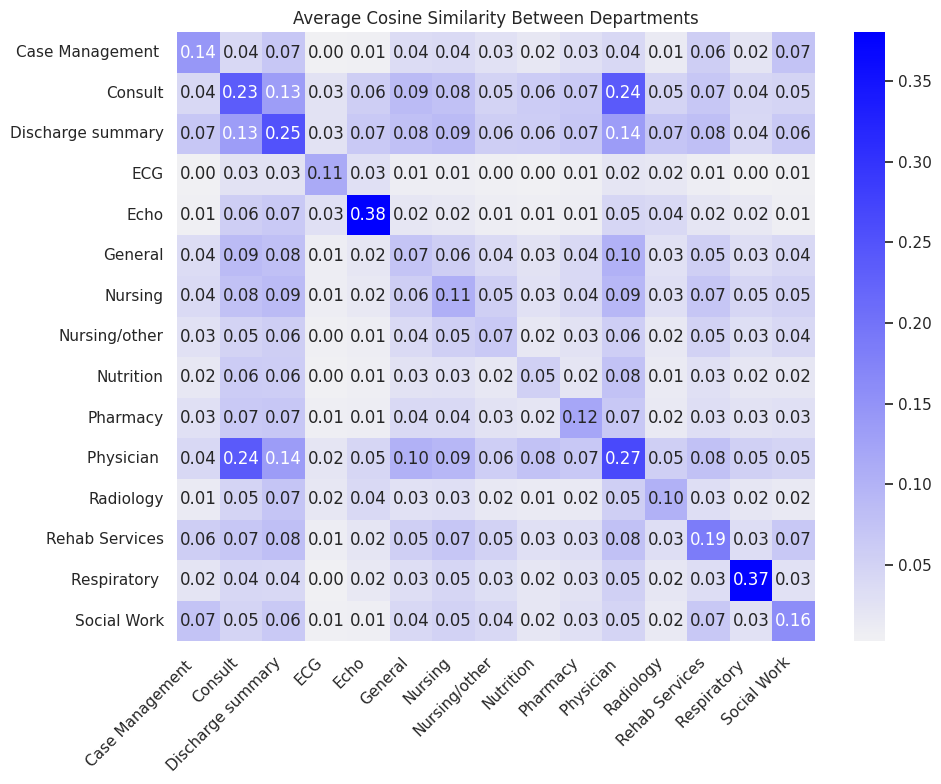

In [47]:
# -------------------------------
# 5. Visualization using Matplotlib (Heatmap)
# -------------------------------

# Convert similarity matrix values to a NumPy array for plotting
# Convert similarity matrix values to a NumPy array for plotting (if needed)
sim_array = similarity_matrix.astype(float).values

# Create a white-to-blue colormap
cmap = sns.light_palette("blue", as_cmap=True)

# Set Seaborn theme for a clean, business professional look
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 8))
# Create the heatmap with annotations and the YlGnBu colormap
ax = sns.heatmap(sim_array, annot=True, fmt=".2f", cmap=cmap,
                 xticklabels=departments, yticklabels=departments)

plt.title("Average Cosine Similarity Between Departments")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heatmap shows high cosine-similarity intra-department. This is to be expected as there is similar terminology used within departments.

#### Visualization Department Cosine Similarity

<ipython-input-52-567f5e461cd6>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


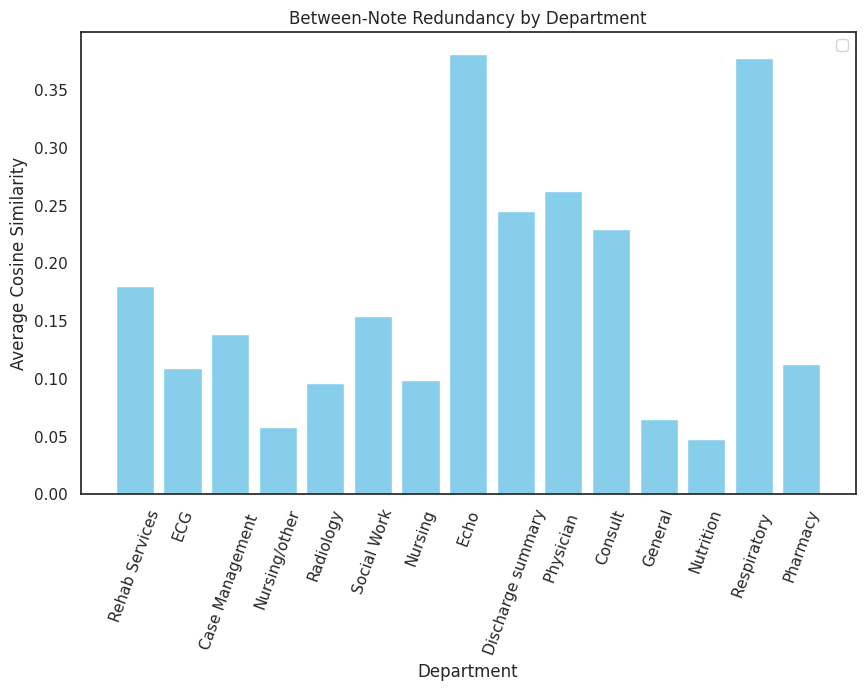

In [52]:
# Create a bar plot comparing the average cosine similarity of each department.
dept_names = list(results.keys())
avg_sims = [results[d] for d in dept_names]

# Set Seaborn theme to a minimal style without gridlines
sns.set_theme(style="white")

plt.figure(figsize=(10, 6))
bars = plt.bar(dept_names, avg_sims, color='skyblue')
# plt.axhline(y=radiology_sim if "Radiology" in results else 0, color='red', linestyle='--', label="Radiology Avg")
plt.xlabel("Department")
plt.ylabel("Average Cosine Similarity")
plt.title("Between-Note Redundancy by Department")
plt.xticks(rotation=70)
plt.legend()
plt.show()

### Within-Note Similarity Analysis

Instead of computing cosine similarity across entire notes, break each note into smaller segments (such as paragraphs or standardized sections like “HPI,” “Assessment,” “Plan”). Then, compute cosine similarity between these segments. A high similarity score (e.g., >0.8) between segments in the same note might reveal internal redundancy.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute within-note redundancy by segmenting the note into sections
def compute_within_note_similarity(note_text):
    """
    Splits a note into segments (using newlines as a simple delimiter), computes
    TF-IDF vectors for each segment, and then calculates the average cosine similarity
    among all pairs of segments.
    A higher average similarity suggests more redundancy in the note.
    """
    # Split the note on newline characters; adjust this if your notes have specific headers.
    segments = [seg.strip() for seg in note_text.split('\n') if seg.strip()]

    # If there is only one segment, no within-note comparison is possible.
    if len(segments) < 2:
        return 0.0

    # Create a TF-IDF representation of the segments
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(segments)

    # Compute the cosine similarity matrix for the segments
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Extract the upper triangle (excluding the diagonal) since the similarity matrix is symmetric.
    n = similarity_matrix.shape[0]
    similarities = []
    for i in range(n):
        for j in range(i + 1, n):
            similarities.append(similarity_matrix[i, j])

    # Return the average similarity as our redundancy measure for the note.
    return np.mean(similarities) if similarities else 0.0


In [54]:
# ------------------------------
# Compute Redundancy Scores (Within-Note)
# ------------------------------

# Compute the within-note similarity for each note
df['within_note_similarity'] = df['TEXT'].apply(compute_within_note_similarity)


In [55]:
# ------------------------------
# Grouping by Department (CATEGORY)
# ------------------------------

# Group the redundancy metric by department (CATEGORY) and compute the average within-note similarity per department
avg_similarity_by_category = df.groupby('CATEGORY')['within_note_similarity'].mean()
print("Average within-note similarity by department:")
print(avg_similarity_by_category)

Average within-note similarity by department:
CATEGORY
Case Management      0.029403
Consult              0.007428
Discharge summary    0.010342
ECG                  0.042978
Echo                 0.027412
General              0.012902
Nursing              0.022986
Nursing/other        0.016237
Nutrition            0.030185
Pharmacy             0.023531
Physician            0.006450
Radiology            0.027242
Rehab Services       0.017235
Respiratory          0.022240
Social Work          0.024886
Name: within_note_similarity, dtype: float64


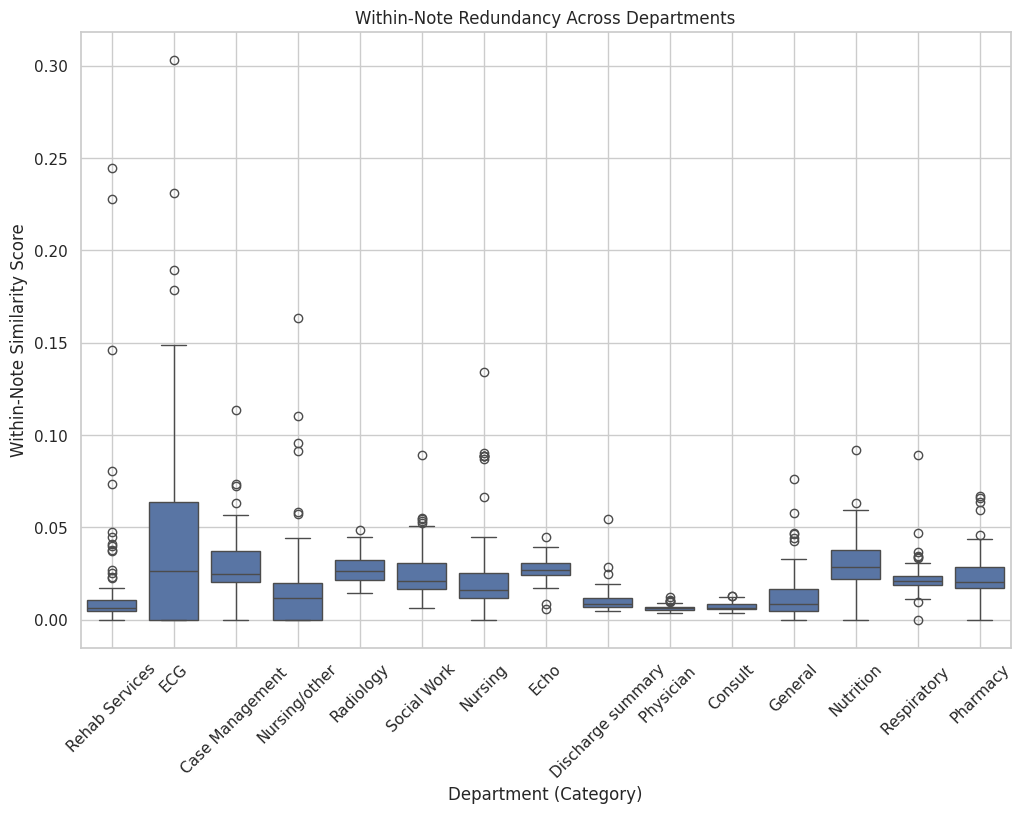

In [56]:
# Visualize the redundancy measures across departments using a boxplot
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(x='CATEGORY', y='within_note_similarity', data=df)
plt.title('Within-Note Redundancy Across Departments')
plt.xlabel('Department (Category)')
plt.ylabel('Within-Note Similarity Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Here we see ECG and Rehab Services have many outliers when it comes to redundancy within notes.

### High Redundancy Notes

In [57]:
df_sorted = df.sort_values(by='within_note_similarity', ascending=False, inplace=False)
print("Top 10 notes with highest within-note similarity:")

# Configure Pandas to display all text in the column.
pd.set_option('display.max_colwidth', None)
df_sorted.head(10)[['TEXT', 'clean_text', 'within_note_similarity']]

Top 10 notes with highest within-note similarity:


,TEXT,clean_text,within_note_similarity
874,Same [**Location (un) 26**] as the second tracing. No significant change.\nTRACING #3\n\n,same location un 26 as the second tracing no significant change tracing 3,0.303216
1068,[**1-19**] Checked in with pt for PT evaluation. Pt still not appropriate\n for PT. Will continue to follow and evaluate as indicated.\n,119 checked in with pt for pt evaluation pt still not appropriate for pt will continue to follow and evaluate as indicated,0.244587
1221,Sinus rhythm. Bigeminal atrial premature beats. Compared to the previous\ntracing of [**2165-6-22**] bigeminal atrial premature beats are new.\nTRACING #2\n\n,sinus rhythm bigeminal atrial premature beats compared to the previous tracing of 2165622 bigeminal atrial premature beats are new tracing 2,0.230882
1325,TITLE: Bedside Swallow Evaluation\n Patient was seen for bedside swallow evaluation. Please see full\n evaluation in OMR or paper chart for details and recommendations.\n,title bedside swallow evaluation patient was seen for bedside swallow evaluation please see full evaluation in omr or paper chart for details and recommendations,0.227952
52,"Atrial fibrillation with a rapid ventricular response and occasional\nventricular ectopy. Compared to the previous tracing of [**2160-6-19**] there is\noccasional ventricular ectopy. Otherwise, no change.\n\n",atrial fibrillation with a rapid ventricular response and occasional ventricular ectopy compared to the previous tracing of 2160619 there is occasional ventricular ectopy otherwise no change,0.189681
930,Sinus rhythm. Ventricular ectopy. Left bundle-branch block. Compared to the\nprevious tracing ventricular ectopy is now present.\n\n,sinus rhythm ventricular ectopy left bundlebranch block compared to the previous tracing ventricular ectopy is now present,0.178566
1131,"SOCIAL WORK\nThis family is known to social work from their prior NICU experience. met with mother to offer support during her son's stay. Mom pleased with infant's progress, eager to have him home when medically ready. Feels that over all things are going well, not feeling the need for additional support. She understands that I will continue to touch base and remain available should a concern arise. Thank-you.\n",social work this family is known to social work from their prior nicu experience met with mother to offer support during her sons stay mom pleased with infants progress eager to have him home when medically ready feels that over all things are going well not feeling the need for additional support she understands that i will continue to touch base and remain available should a concern arise thankyou,0.163204
804,Artifact is present. Irregular rhythm that may be atrial fibrillation. Left\naxis deviation. Left bundle-branch block. Compared to the previous tracing\nof [**2166-1-3**] the rhythm may have changed and left bundle-branch block is new.\nTRACING #1\n\n,artifact is present irregular rhythm that may be atrial fibrillation left axis deviation left bundlebranch block compared to the previous tracing of 216613 the rhythm may have changed and left bundlebranch block is new tracing 1,0.148760
1105,TITLE: Bedside Swallow Evaluation\n Patient was seen for bedside swallow evaluation on [**2144-2-26**]. Please see\n full note in OMR for details and recommendations.\n,title bedside swallow evaluation patient was seen for bedside swallow evaluation on 2144226 please see full note in omr for details and recommendations,0.146036
383,Sinus rhythm. Intraventricular conduction delay. Slight ST segment\ndepressions in leads V5-V6. Compared to the previous tracing sinus rhythm has\nbeen restored and ST segment depressions are less prominent.\nTRACING #4\n\n,sinus rhythm intraventricular conduction delay slight st segment depressions in leads v5v6 compared to the previous tracing sinus rhythm has been restored and st segment depressions are less prominent tracing 4,0.138401


In [58]:
### 1. Functions for Segmenting and Redundancy Analysis

def segment_text(note_text):
    """
    Splits a note into segments.
    This simple approach splits on newline characters.
    You can refine this function based on known section headers.
    """
    segments = [seg.strip() for seg in note_text.split('\n') if seg.strip()]
    return segments

def find_redundant_segments(note_text, similarity_threshold=0.9):
    """
    Identifies repeated (highly similar) segments within a note.

    Parameters:
      note_text (str): The full text of the clinical note.
      similarity_threshold (float): Cosine similarity threshold above which
                                    two segments are considered redundant.

    Returns:
      repeated_segments (list of str): List of segments that are part of redundant pairs.
    """
    segments = segment_text(note_text)
    if len(segments) < 2:
        return []  # Not enough segments for comparison

    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(segments)
    sim_matrix = cosine_similarity(tfidf_matrix)

    # Use a set to avoid duplicate entries
    repeated_indices = set()
    n = len(segments)
    for i in range(n):
        for j in range(i+1, n):
            if sim_matrix[i, j] >= similarity_threshold:
                repeated_indices.add(i)
                repeated_indices.add(j)

    # Gather the repeated segments based on indices
    repeated_segments = [segments[i] for i in sorted(repeated_indices)]
    return repeated_segments



In [59]:
# A manually defined list of keywords that we deem to be clinically valuable.
valuable_keywords = [
    # Cardiovascular Conditions
    'chest pain', 'angina', 'myocardial infarction', 'MI',
    'heart failure', 'cardiac arrest', 'arrhythmia',
    'atrial fibrillation', 'ventricular tachycardia',
    'coronary artery disease',

    # Metabolic & Endocrine Conditions
    'diabetes', 'hyperglycemia', 'hypoglycemia',

    # Respiratory Conditions and Interventions
    'pneumonia', 'sepsis', 'septic shock', 'infection',
    'respiratory failure', 'intubation', 'mechanical ventilation',
    'ventilator',

    # Neurological Conditions
    'stroke', 'cerebrovascular accident', 'intracranial hemorrhage',
    'altered mental status', 'confusion', 'encephalopathy', 'seizure',

    # Oncology
    'cancer', 'neoplasm', 'malignancy',

    # Surgical and Procedural Terminology
    'surgery', 'operative', 'laparoscopy', 'open surgery',
    'robotic surgery',

    # Chronic vs. Acute Conditions
    'hypertension', 'high blood pressure', 'chronic', 'acute',

    # Renal Function and Fluid Management
    'acute kidney injury', 'renal failure', 'oliguria', 'anuria',
    'fluid resuscitation',

    # Shock and Emergency Presentations
    'shock', 'cardiogenic shock', 'distributive shock', 'hypovolemic shock',

    # Diagnostics, Imaging, and Lab Monitoring
    'ECG', 'EKG', 'CT scan', 'MRI', 'ultrasound', 'radiography', 'X-ray',
    'blood pressure', 'heart rate', 'oxygen saturation', 'respiratory rate',
    'lab results', 'blood tests', 'CBC', 'BMP', 'electrolytes',
    'liver function', 'leukocytosis', 'thrombocytopenia', 'anemia', 'hypoxia',

    # Medications, Therapies, and Documentation
    'medication', 'pharmacotherapy', 'antibiotic', 'vasopressor', 'sedative',
    'treatment', 'therapy', 'diagnosis', 'assessment', 'plan', 'consultation',
    'ICU', 'emergency', 'ER', 'critical care', 'intensive care',

    # Other Relevant Clinical Terminologies
    'dysrhythmia', 'coagulopathy', 'bleeding', 'hemorrhage', 'transfusion',
    'discharge', 'admission', 'readmission'
]


In [60]:
### 2. Functions for Evaluating Clinical Value
def is_segment_valuable(segment, valuable_keywords):
    """
    Checks if a segment contains any of the valuable keywords.
    The comparison is case-insensitive.

    Returns:
      bool: True if the segment contains a valuable keyword, False otherwise.
    """
    segment_lower = segment.lower()
    for keyword in valuable_keywords:
        if keyword in segment_lower:
            return True
    return False

def evaluate_note_value(note_text, similarity_threshold=0.9):
    """
    Determines the "value" of the repeated content in a note.

    Parameters:
      note_text (str): The cleaned text of the note.
      similarity_threshold (float): Threshold to identify highly similar segments.

    Returns:
      value_ratio (float): Ratio of repeated segments that are considered valuable.
                           (0.0 if no repetition exists.)
      repeated_segments (list of str): The repeated segments extracted.
    """
    repeated_segments = find_redundant_segments(note_text, similarity_threshold)
    if not repeated_segments:
        return 0.0, []

    # Count the number of valuable segments
    valuable_count = sum(is_segment_valuable(seg, valuable_keywords) for seg in repeated_segments)
    value_ratio = valuable_count / len(repeated_segments)
    return value_ratio, repeated_segments


In [61]:
### 3. Identify and Analyze High Redundancy Notes

# Determine the threshold for high redundancy
high_redundancy_threshold = df['within_note_similarity'].quantile(0.50)
high_red_notes = df[df['within_note_similarity'] > high_redundancy_threshold]

print(f"Number of high redundancy notes: {len(high_red_notes)}")

# Evaluate each high redundancy note for valuable content in its repetitions
analysis_results = []
for idx, row in high_red_notes.iterrows():
    note_text = row['clean_text']
    value_ratio, repeated_segments = evaluate_note_value(note_text, similarity_threshold=0.9)

    # Record information about the note and its repeated content
    analysis_results.append({
        'ROW_ID': row['ROW_ID'],
        'CATEGORY': row['CATEGORY'],
        'within_note_similarity': row['within_note_similarity'],
        'value_ratio': value_ratio,
        'num_repeated_segments': len(repeated_segments),
        'repeated_segments': repeated_segments
    })

results_df = pd.DataFrame(analysis_results)

Number of high redundancy notes: 735


In [62]:
### 4. Display and Interpret the Results

# Show a summary of high redundancy notes and their valuable content ratio.
print("High Redundancy Note Analysis:")
print(results_df[['ROW_ID', 'CATEGORY', 'within_note_similarity', 'value_ratio', 'num_repeated_segments']])

# For further review, you can examine notes with low value ratio (i.e., many repetitive, non-valuable segments)
low_value_notes = results_df[results_df['value_ratio'] < 0.7]
print("\nHigh redundancy notes with low valuable content ratio:")
print(low_value_notes[['ROW_ID', 'CATEGORY', 'within_note_similarity', 'value_ratio']])

# Optionally, inspect the details of one note (e.g., first in the low_value_notes subset)
if not low_value_notes.empty:
    example = low_value_notes.iloc[0]
    print("\nExample Note Details:")
    print("ROW_ID:", example['ROW_ID'])
    print("CATEGORY:", example['CATEGORY'])
    print("Within-Note Similarity:", example['within_note_similarity'])
    print("Value Ratio:", example['value_ratio'])
    print("Repeated Segments:")
    for seg in example['repeated_segments']:
        print("-", seg)

High Redundancy Note Analysis:
      ROW_ID       CATEGORY  within_note_similarity  value_ratio  \
0     904351      Radiology                0.041934          0.0   
1    1201581      Radiology                0.023463          0.0   
2    1046799      Radiology                0.027391          0.0   
3    1336705  Nursing/other                0.019582          0.0   
4      59850           Echo                0.032522          0.0   
..       ...            ...                     ...          ...   
730   130374            ECG                0.027959          0.0   
731   329439      Nutrition                0.031792          0.0   
732   398555      Nutrition                0.037997          0.0   
733   698756       Pharmacy                0.041673          0.0   
734   459381      Nutrition                0.033755          0.0   

     num_repeated_segments  
0                        0  
1                        0  
2                        0  
3                        0  
4      

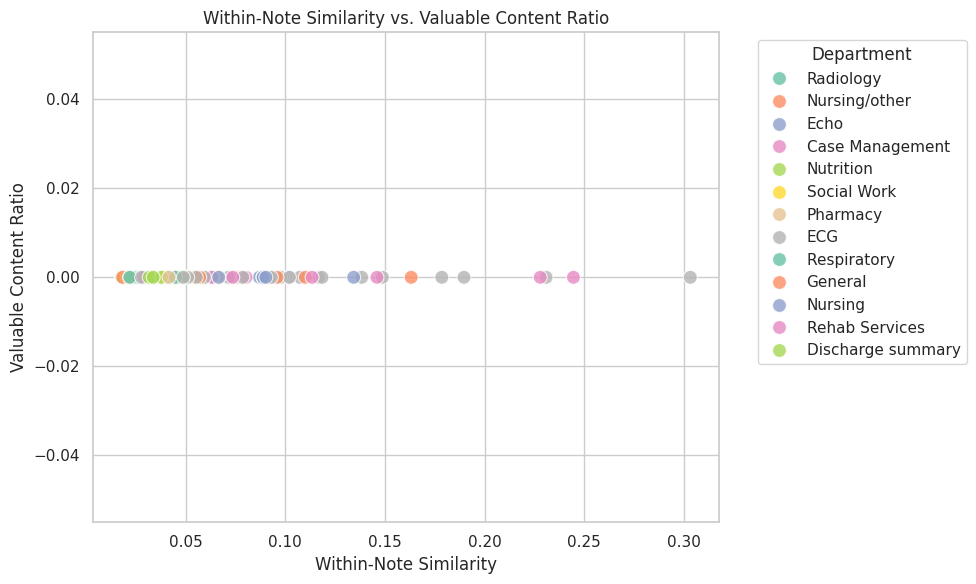

In [63]:
# --- Visualization 1: Scatter Plot ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=results_df,
    x='within_note_similarity',
    y='value_ratio',
    hue='CATEGORY',
    palette='Set2',
    s=100,
    alpha=0.8
)
plt.title('Within-Note Similarity vs. Valuable Content Ratio')
plt.xlabel('Within-Note Similarity')
plt.ylabel('Valuable Content Ratio')
plt.legend(title='Department', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Template Review and Policy

Identify frequently pasted blocks of text.

In [64]:
# Function to split a note into segments and filter by a minimum length
def get_template_segments(note_text, min_len=30):
    """
    Splits a note into segments using newline as delimiter and filters out segments
    that are shorter than min_len characters.
    """
    segments = [seg.strip() for seg in note_text.split('\n') if len(seg.strip()) >= min_len]
    return segments


In [65]:
# Aggregate segments from all notes in the DataFrame.
all_segments = []
for note in df['TEXT']:
    segments = get_template_segments(note)
    all_segments.extend(segments)


In [66]:
# Count the frequency of each segment.
segment_counter = Counter(all_segments)

# Filter segments that appear frequently (e.g., at least 5 times).
min_occurrences = 5
frequent_templates = {seg: count for seg, count in segment_counter.items() if count >= min_occurrences}

print("Frequently pasted blocks of text (appearing at least 5 times):")
for seg, count in sorted(frequent_templates.items(), key=lambda item: item[1], reverse=True):
    print(f"\nOccurrence: {count}\nText:\n{seg}\n{'-'*60}")

Frequently pasted blocks of text (appearing at least 5 times):

Occurrence: 215
Text:
______________________________________________________________________________
------------------------------------------------------------

Occurrence: 101
Text:
Review of systems is unchanged from admission except as noted below
------------------------------------------------------------

Occurrence: 95
Text:
Changes to medical and family history:
------------------------------------------------------------

Occurrence: 78
Text:
Assessment of Nutritional Status
------------------------------------------------------------

Occurrence: 77
Text:
Medical Nutrition Therapy Plan - Recommend the Following
------------------------------------------------------------

Occurrence: 76
Text:
Heart rhythm: SR (Sinus Rhythm)
------------------------------------------------------------

Occurrence: 71
Text:
[**Hospital 2**] MEDICAL CONDITION:
------------------------------------------------------------

Occurrenc

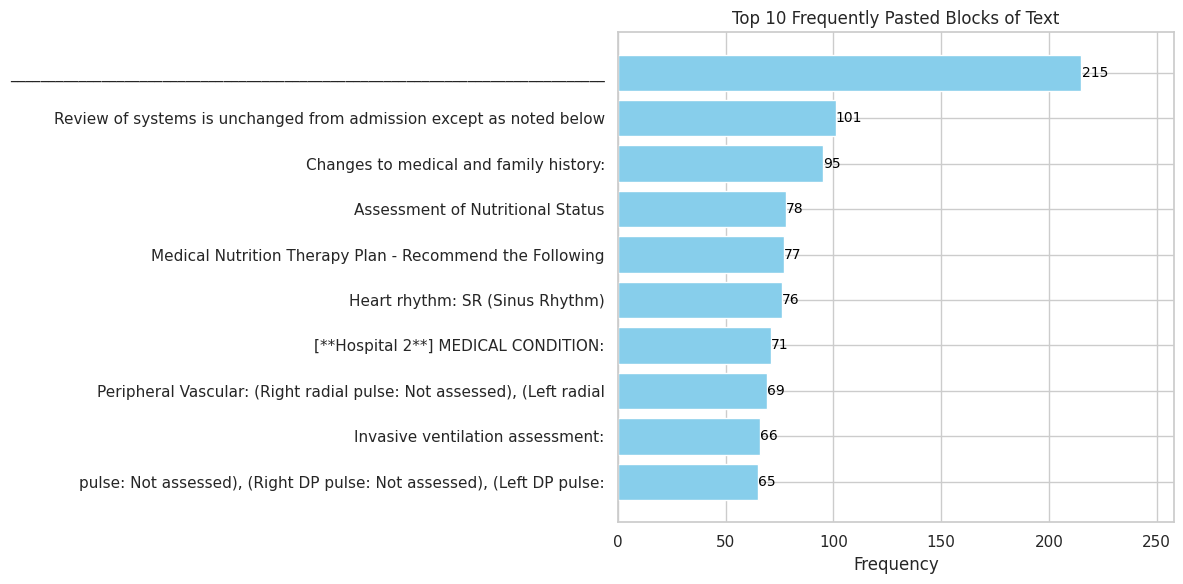

In [67]:
# Visualize the top 10 frequently pasted segments
top_n = 10
top_segments = Counter(frequent_templates).most_common(top_n)

if top_segments:
    segments_texts = [seg for seg, count in top_segments]
    counts = [count for seg, count in top_segments]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(segments_texts, counts, color='skyblue')
    plt.xlabel("Frequency")
    plt.title("Top 10 Frequently Pasted Blocks of Text")
    plt.gca().invert_yaxis()  # Highest frequency at the top

    # Extend x-axis to leave space for labels.
    max_count = max(counts)
    plt.xlim(0, max_count * 1.2)

    # Add numerical values to the end of each bar.
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
                str(width), va='center', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

else:
    print("No template segments met the frequency threshold.")

## Deduplication

In [8]:
# Load the clinical embedding model (BioBERT version via SentenceTransformer)
# This model is tuned for clinical texts. You can choose others if desired.
# This model is trained on the MIMIC 3 dataset so this may need to be modified
model = SentenceTransformer("emilyalsentzer/Bio_ClinicalBERT")

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [15]:
def adaptive_segment_text(text, min_segments=2):
    """
    Segments text adaptively:
      - First, attempts to split using newline characters.
      - If the result yields fewer than min_segments segments, fall back to
        sentence tokenization.

    Parameters:
      text (str): The text to segment.
      min_segments (int): Minimum number of segments expected; if fewer are
                          found with newline splitting, use sentence segmentation.

    Returns:
      List of segments (strings).
    """
    # First, try splitting on newlines
    segments = [seg.strip() for seg in text.split('\n') if seg.strip()]

    # If segmentation by newlines yields too few segments, use sentence tokenization.
    if len(segments) < min_segments:
        segments = sent_tokenize(text)

    # Optionally, filter out segments that are too short (which might be noise)
    segments = [seg for seg in segments if len(seg) > 20]  # adjust the threshold as needed
    return segments


In [18]:
# Deduplication function using a greedy similarity-threshold approach.
def deduplicate_note_greedy(note_text, similarity_threshold=0.9):
    """
    Automatically deduplicates repeated content in a note.

    Process:
      - Split the note into segments (e.g., by newline).
      - Compute clinical embeddings for each segment.
      - Greedily iterate over segments: for each new segment, if its
        cosine similarity with any previously retained segment exceeds the threshold,
        treat it as duplicate and skip it.
      - Otherwise, retain the segment.

    Returns:
      The deduplicated note text, with unique segments joined by newlines.
    """
    segments = adaptive_segment_text(note_text, min_segments=3)
    if not segments:
        return note_text  # Return original text if no segments found.

    # Compute embeddings for each segment.
    embeddings = model.encode(segments, convert_to_numpy=True)

    # Normalize embeddings to unit vectors for cosine similarity.
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normed_embeddings = embeddings / (norms + 1e-10)  # add a small constant to avoid division by zero

    dedup_indices = []  # indices of segments to retain
    for i, candidate_embedding in enumerate(normed_embeddings):
        is_duplicate = False
        for j in dedup_indices:
            # Compute cosine similarity between candidate segment and previously kept segment.
            sim = np.dot(candidate_embedding, normed_embeddings[j])
            if sim >= similarity_threshold:
                is_duplicate = True
                break
        if not is_duplicate:
            dedup_indices.append(i)

    # Reconstruct the note from the deduplicated segments.
    deduplicated_segments = [segments[i] for i in dedup_indices]
    deduped_note = "\n".join(deduplicated_segments)
    return deduped_note


In [23]:
# Replace this sample text with one of your clinical notes from your DataFrame (e.g., df['clean_text'].iloc[0])
sample_note = """
PT. REMAINS LIGHTLY SEDATED ON BOTH FENTANYL AND VERSED GTT'S. PT. AWAKE EASILY AND NODS HEAD TO QUESTIONS ASKED BYT THE TEAM. PT. REMAINS AFEBRILE THROUGHOUT THIS SHIFT WITH WBC'S WNL'S. PT. HAS REMAINED NSR 70-90'S WITH NO NOTED ECTOPY. B/P COTINUES TO BE SUPPORTED BY DOPAMINE PRESENTLY AT 2.2MCG/KG/MIN. PT. IS OM ROUTINE SINEMET TO AID IN TRANSITION TO WEAN OFF DOPAMINE. PT. REMAINS INTUBATED, WITH NO VENT CHANGES MADE DURING THIS SHIFT. PT. HAS BEEN SUCTIONED FOR MINIMAL AMT'S OF CLEAR/WHITE SECRETIONS. PT'S LUNG SOUND WERE COARSE AND DIMINISHED INTHE BASES, THIS HAS IMPROVED THIS AM. NOW RIGHT SIDE HAS CLEARED SIGNIFICANTLY, STILL DIMINISHED BIBASILAR. O2 SATS >98% AND RESP RATE CONTROLLED. PT. CONTINUES TO TUBE FEEDS AT GOAL RATE OF 55CC/HR ON RESPALOR. RESIDUALS ARE MINIMAL. BLOOD SUGARS HAVE BEEN [**Name (NI) 9503**] WITH PT. RECEIVING HIS AM INSULIN DOSE. BOWEL SOUNDS ARE EASILY AUDIBLE WITH NO STOOL THIS SHIFT. PT. REMAINS ON CVVHD WITH GOAL OF RUNNING EVEN. THERE WAS A TWO HR PERIOD BETWEEN MACHINE CLOTTING OFF AND NEW MACHINE SETUP. AM LABS DRAW AND BOTH POTASSIUM AND CALCIUM GTT'S TITRATED PER DOCTERS ORDERS. HEPARIN DOSING STARTED PER CVVHD AS WELL. ALL PT'S LINES ARE INTACT ANS SECURED, AND FUNCTIONING WELL.\nPT. REMAINS A FULL CODE AT THIS TIME. [**Name (NI) **] WIFE WAS UPDATED LAST EVENING ON PT'S STATUS. PT. HAS BEEN STATED ON SINEMET WITH HOPES TO WEAN OFF DOPAMINE GTT. PT. IS FOR POSSIBLE TRACH EVAL FROM SURGERY. OTHERWISE PT. REMAINS STABLE.\n
"""

print("Original Note:")
print(sample_note)
print("\n---\n")

deduped_note = deduplicate_note_greedy(sample_note, similarity_threshold=0.9)

print("Deduplicated Note:")
print(deduped_note)

print(f"\n---\nOriginal Note Length: {len(sample_note)}")
print(f"Deduplicated Note Length: {len(deduped_note)}")

Original Note:

PT. REMAINS LIGHTLY SEDATED ON BOTH FENTANYL AND VERSED GTT'S. PT. AWAKE EASILY AND NODS HEAD TO QUESTIONS ASKED BYT THE TEAM. PT. REMAINS AFEBRILE THROUGHOUT THIS SHIFT WITH WBC'S WNL'S. PT. HAS REMAINED NSR 70-90'S WITH NO NOTED ECTOPY. B/P COTINUES TO BE SUPPORTED BY DOPAMINE PRESENTLY AT 2.2MCG/KG/MIN. PT. IS OM ROUTINE SINEMET TO AID IN TRANSITION TO WEAN OFF DOPAMINE. PT. REMAINS INTUBATED, WITH NO VENT CHANGES MADE DURING THIS SHIFT. PT. HAS BEEN SUCTIONED FOR MINIMAL AMT'S OF CLEAR/WHITE SECRETIONS. PT'S LUNG SOUND WERE COARSE AND DIMINISHED INTHE BASES, THIS HAS IMPROVED THIS AM. NOW RIGHT SIDE HAS CLEARED SIGNIFICANTLY, STILL DIMINISHED BIBASILAR. O2 SATS >98% AND RESP RATE CONTROLLED. PT. CONTINUES TO TUBE FEEDS AT GOAL RATE OF 55CC/HR ON RESPALOR. RESIDUALS ARE MINIMAL. BLOOD SUGARS HAVE BEEN [**Name (NI) 9503**] WITH PT. RECEIVING HIS AM INSULIN DOSE. BOWEL SOUNDS ARE EASILY AUDIBLE WITH NO STOOL THIS SHIFT. PT. REMAINS ON CVVHD WITH GOAL OF RUNNING EVEN. T

## Next Steps

### Measure Outcome

Recompute similarity scores after de-bloating.

Evaluate whether reducing internal redundancy improves readability and NLP model performance.

